# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

**Необходимо:**

- Построить модель для определения региона, где добыча принесёт наибольшую прибыль.

- Проанализировать возможную прибыль и риски (техникой Bootstrap).

# Описание данных

`id` — уникальный идентификатор скважины;

`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

`product` — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [ ]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   OrdinalEncoder)

from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  на месте
</div>



### Загрузка файлов

In [ ]:
# чтение и загрузка файлов по каждому региону
reg_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',', decimal = '.')
display(reg_0.head())
reg_0.shape

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


(100000, 5)

In [ ]:
# чтение и загрузка файлов по каждому региону
reg_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',', decimal = '.')
display(reg_1.head())
reg_1.shape

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


(100000, 5)

In [ ]:
# чтение и загрузка файлов по каждому региону
reg_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',', decimal = '.')
display(reg_2.head())
reg_2.shape

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


(100000, 5)

**Вывод:** Данные загружены корректно, размерность всех таблиц проверена. Данные в таблицах соответвуют описанию.

### Предобработка данных

In [ ]:
# проверим формат данных

for dataframe in [reg_0, reg_1, reg_2]:
    print(dataframe.info())
    print('________________________\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
________________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
________________________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to

Форматы данных корректны.

In [ ]:
# проверяем пропуски в таблицах по регионам

for dataframe in [reg_0, reg_1, reg_2]:
    print(dataframe.isna().sum().sort_values(ascending=False))
    print('________________________\n')

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
________________________

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
________________________

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
________________________



Пропуски отстуствуют.

In [ ]:
# проверяем на дубликаты

for dataframe in [reg_0, reg_1, reg_2]:
    print(dataframe.duplicated().sum())
    print('________________________\n')

0
________________________

0
________________________

0
________________________



Дубликаты отстуствуют.

### Исследовательский анализ

**Статистический анализ всех признаков**

In [ ]:
# для статистического анализа по всем признакам воспользуемся функцией describe
# она доступна только для числовых столбцов

for dataframe in [reg_0, reg_1, reg_2]:
    print(dataframe.__class__.__name__)
    print(dataframe.describe())
    print('________________________\n')


DataFrame
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347
________________________

DataFrame
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.2

Судя по статистическим показателям регионы имеют сходства и различия между собой:

* средние значения признаков f0 и f1 в reg_0 и reg_2 стремятся к нулевым значениям, а в регионе reg_1 среднее значение f0 и f1 равно 1 и -5 соотвественно

* среднее значение признака f2 во всех трех регионах одинаковое и равно 2.5

* среднее значение объёмов запасов в скважине в регионах reg_0 и reg_2 практически одинаковое 92-95 тыс. баррелей. А в регионе reg_1 средний объем запасов 69 тыс. баррелей, то есть значительно ниже.

* по минимальным значениям признаков f0, f1 и f2 регионы также различаются. Самые минимумы у региона reg_1 у признаков f0 и f1 ниже -25, хотя показатель f2 у этого региона практически равен 0. А, например, у других регионов reg_0 и reg_2, наоборот, показатель min f2 -11/-12

* по максимальным значениям похожая картина по показателям f0, f1 в регионах reg_0 и reg_2, в то время как в регионе  reg_1 максимальные значения 29 и 18 соотвественно.
___________________________________________________

**Мы можем сделать общий вывод, что регионы reg_0 и reg_2 имеют похожие между собой характеристики по значеням признаков, а регион reg_1 имеет существенное отличие от остальных.**

<div class="alert alert-block alert-success">
<b>Успех:</b> Верное заключение scatter_plot дальше это отлично демонстрирует.

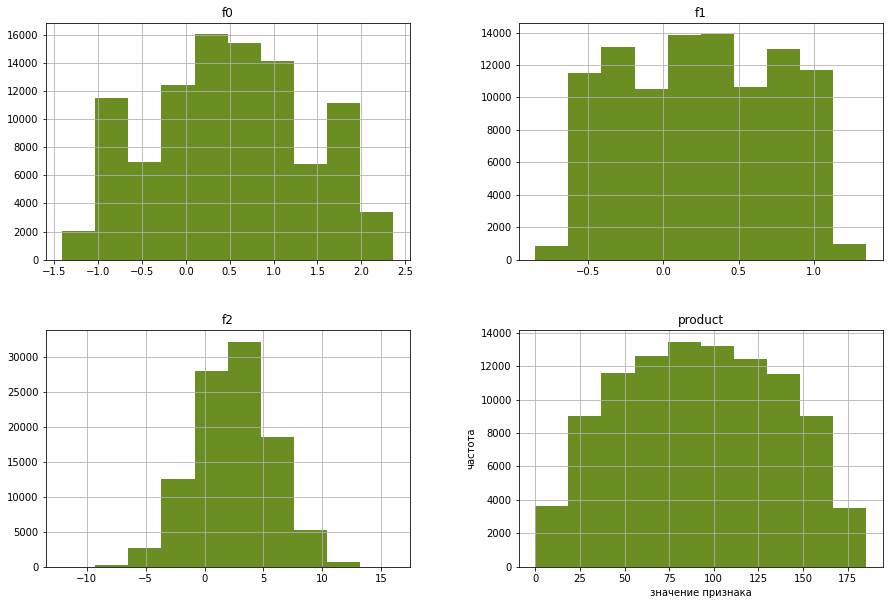

In [ ]:
# построим график для количественных признаков датасета *reg_0*

color = 'olivedrab'
col_reg_0 = reg_0[['f0',
                     'f1',
                     'f2',
                     'product']]
col_reg_0.hist(figsize=(15, 10), bins=10, color=color)
plt.xlabel('значение признака')
plt.ylabel('частота');

**Вывод reg_0:**

-- Гистограммы по показателям f2 и product имеют распределение значений, похожее на нормальное. Объем запасов в скважине варьируется от местонахождения самой скважины.

-- по Гистограммам по показателям f0 и f1 можно предположить, что эти признаки либо взаимозависящие др от др, либо дублирующие , так как графически похожи по частоте распределения значений и имеют по 2 симметричные вершины

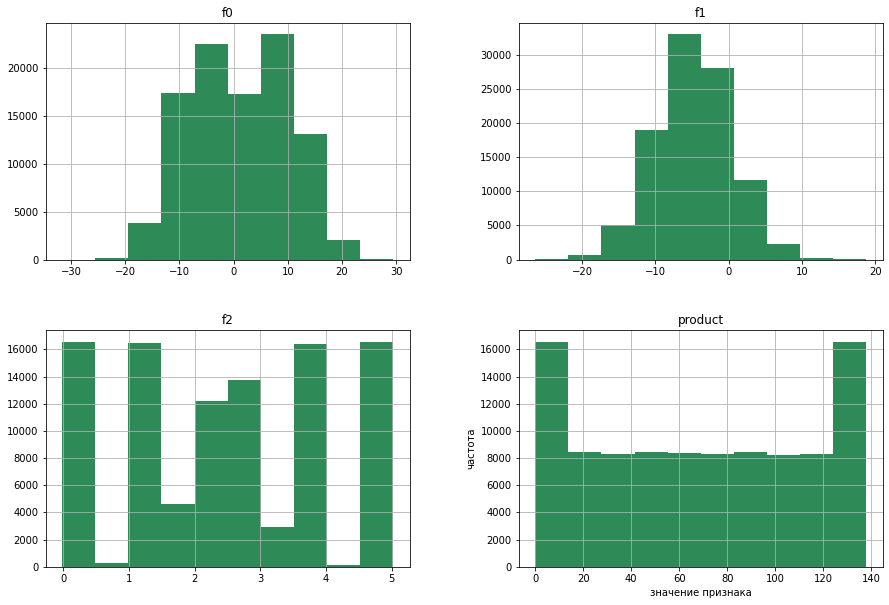

In [ ]:
# построим график для количественных признаков датасета *reg_1*

color1 = 'seagreen'
col_reg_1 = reg_1[['f0',
                     'f1',
                     'f2',
                     'product']]
col_reg_1.hist(figsize=(15, 10), bins=10, color=color1)
plt.xlabel('значение признака')
plt.ylabel('частота');

**Вывод reg_1:** по этому региону картина совершенно другая

-- Гистограмма по показателю f0 имеет 2 вершины

-- Гистограмма по показателю f1 имеет распределение значений, похожее на нормальное  

-- Гистограмма по показателю f2 имеет как будто отражает распределение значений по 5-балльной шкале, хотя в регоионе reg_0 совершенно другая картина.

-- по Гистограмме по показателю product можно сказать, что в данном регионе вцелом стабильные объёмы запасов в скважинах. при этом есть так называемые "выбросы", когда объемов вообще нет, либо их максимально много.


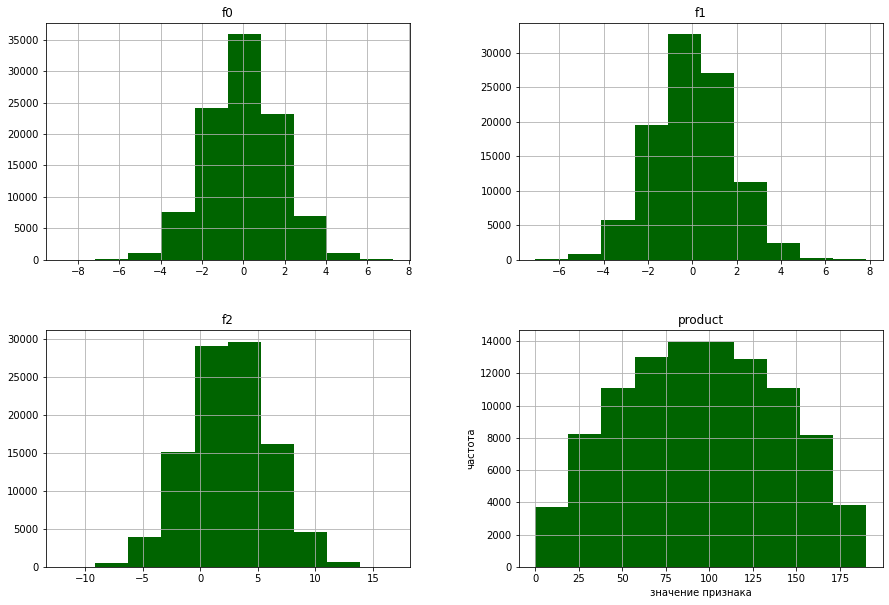

In [ ]:
# построим график для количественных признаков датасета *reg_2*

color2 = 'darkgreen'
col_reg_2 = reg_2[['f0',
                     'f1',
                     'f2',
                     'product']]
col_reg_2.hist(figsize=(15, 10), bins=10, color=color2)

plt.xlabel('значение признака')
plt.ylabel('частота');

**Вывод reg_2:** по этому региону наблюдаем "красивое" четкое распределение значений

-- Гистограммы по всем четырем показателям имеют нормальное распределение значений, что говорит о высоком качестве данных.

-- На всех графиках видим симметричное распределение значений.

-- Показатели f0 и f1 также, как и в регионе reg_0 аналогично "повторяют" друг друга.

### Корреляционный анализ

**Матрица корреляции и ее коэффициенты**

In [ ]:
# для построения матрицы корреляции и расчета ее коэффициентов берем только колиечтвенные признаки
columns_corr = ['f0', 'f1', 'f2', 'product']

In [ ]:
# построим матрицу корреляции *reg_0*

reg0_matrix = reg_0[columns_corr].corr()
display(reg0_matrix)

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


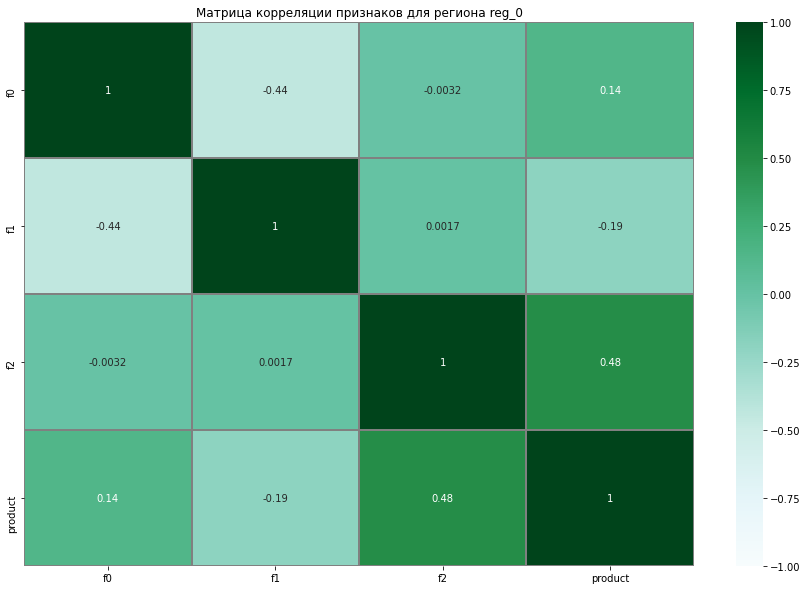

In [ ]:
# отразим матрицу корреляции графически *reg_0*

plt.figure(figsize = (15, 10))
sns.heatmap(reg0_matrix, vmin=-1, vmax=1,
            cmap='BuGn', annot=True,
            linecolor='grey', linewidths=1,
            yticklabels=columns_corr,
            xticklabels=columns_corr)
plt.title('Матрица корреляции признаков для региона reg_0')
plt.show()

**Для региона reg_0 незначительная корреляция (<0,5) между признаками: f0 - f1 (отрицательная), f2 - product.**

In [ ]:
# построим матрицу корреляции *reg_1*

reg1_matrix = reg_1[columns_corr].corr()
display(reg1_matrix)

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


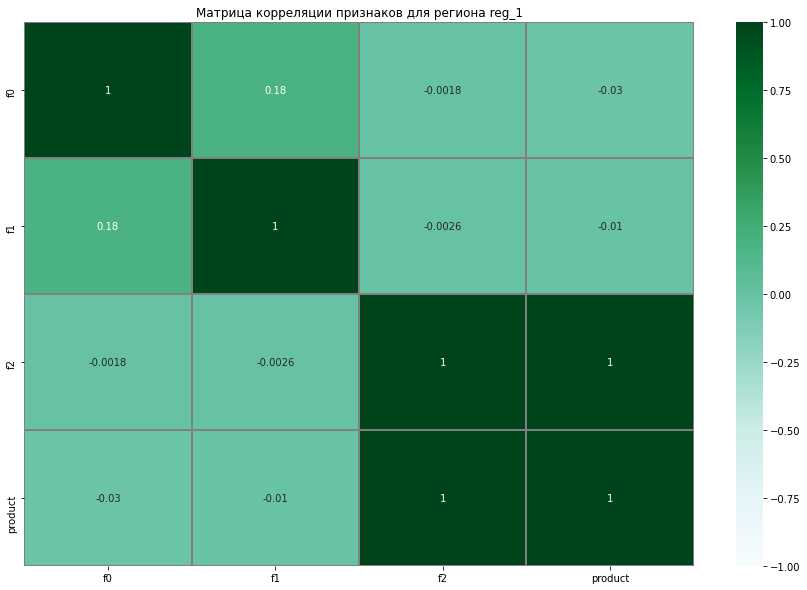

In [ ]:
# отразим матрицу корреляции графически *reg_1*

plt.figure(figsize = (15, 10))
sns.heatmap(reg1_matrix, vmin=-1, vmax=1,
            cmap='BuGn', annot=True,
            linecolor='grey', linewidths=1,
            yticklabels=columns_corr,
            xticklabels=columns_corr)
plt.title('Матрица корреляции признаков для региона reg_1')
plt.show()

**Для региона reg_1 сильная корреляция (=1) между признаками: f2 - product.** В таких случаях лучше удалять признак f2 при обучении модели.

In [ ]:
# построим матрицу корреляции *reg_2*

reg2_matrix = reg_2[columns_corr].corr()
display(reg2_matrix)

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


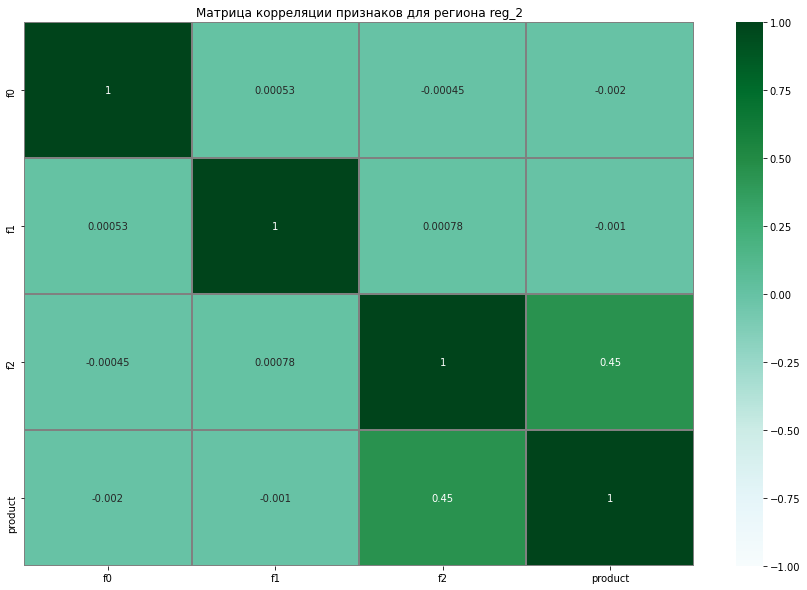

In [ ]:
# отразим матрицу корреляции графически *reg_2*

plt.figure(figsize = (15, 10))
sns.heatmap(reg2_matrix, vmin=-1, vmax=1,
            cmap='BuGn', annot=True,
            linecolor='grey', linewidths=1,
            yticklabels=columns_corr,
            xticklabels=columns_corr)
plt.title('Матрица корреляции признаков для региона reg_2')
plt.show()

**Для региона reg_2 незначительная корреляция (<0,5) между признаками: f2 - product.**

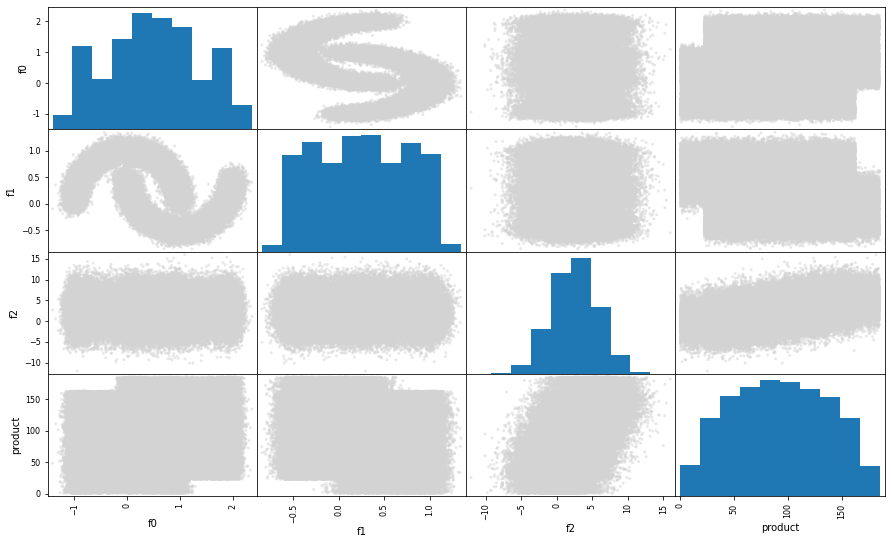

In [ ]:
# Построим матрицу рассеяния для наглядности reg_0

pd.plotting.scatter_matrix(reg_0, figsize=(15, 9), color='lightgrey');

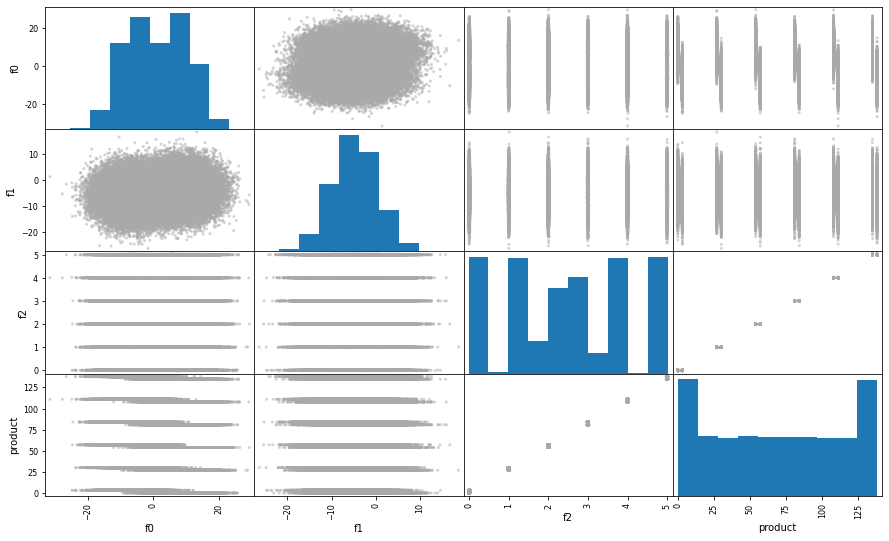

In [ ]:
# Построим матрицу рассеяния для наглядности reg_1

pd.plotting.scatter_matrix(reg_1, figsize=(15, 9), color='darkgrey');

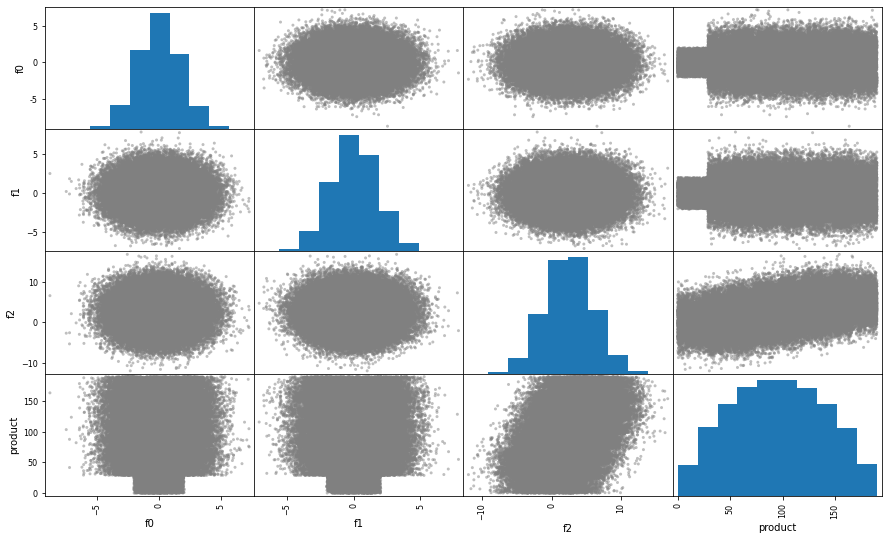

In [ ]:
# Построим матрицу рассеяния для наглядности reg_2

pd.plotting.scatter_matrix(reg_2, figsize=(15, 9), color='grey');

**Вывод по разделу:**
    
1) Данные загружены корректно, размерность всех таблиц проверена. Данные в таблицах соответвуют описанию.

2) Пропуски и дубликаты отсутствуют

3) На основе статистического анализа сформировали общий вывод, что регионы reg_0 и reg_2 имеют похожие между собой характеристики по значеням признаков, а регион reg_1 имеет существенное отличие от остальных.

4) Корреляционный анализ показал, что: Для регионов reg_0 и reg_2 незначительная корреляция (<0,5) между признаками: f0 - f1 (отрицательная), f2 - product. Для региона reg_1 сильная корреляция (=1) между признаками: f2 - product.

5) По графикам матриц рассеяния для регионов reg_0 и reg_2 видна положительная зависимость между показателями f2 - product. Для регоиона reg_1 по матрице рассеяния зависимости между признаками нет, кроме явной корреляциия f2 - product (положительная прямая зависимость)

## Обучение и проверка модели

Целевой признак для построения модели - **product — объём запасов в скважине (тыс. баррелей).**

### Модель 1 для датасета reg_0

**Подготовка данных**

In [ ]:
# создание константы RANDOM_STATE

RANDOM_STATE = 42

In [ ]:
# определяем целевой показатель

X = reg_0.drop(['id','product'], axis=1)
y = reg_0['product']

**Разделение данных на обучающую и валидационную выборки в соотношении 75:25**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
# проверим размеры выборок
# признаки обучения:

for data in [X_train, X_valid, y_train, y_valid]:
    print(data.shape)
    print('________________________\n')

(75000, 3)
________________________

(25000, 3)
________________________

(75000,)
________________________

(25000,)
________________________



In [ ]:
# проверим соотношение выборок

print(f'Обучающая выборка составляет: {X_train.shape[0]/reg_0.shape[0]:.1%} % от общего массива данных.')
print(f'Валидационная выборка составляет: {X_valid.shape[0]/reg_0.shape[0]:.1%} % от общего массива данных.')


Обучающая выборка составляет: 75.0% % от общего массива данных.
Валидационная выборка составляет: 25.0% % от общего массива данных.


In [ ]:
# масштабируем количественные признаки

scaler = StandardScaler()

# список всех количественных признаков из тренировочной выборки
num_col_names = ['f0', 'f1', 'f2']

# обучим и трансформируем количественные признаки из тренировочной выборки

X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование количественных признаков в тестовой выборке
X_valid_scaled = scaler.transform(X_valid[num_col_names])

In [ ]:
# создаём тренировочный и валидационный датафреймы из отмасштабированных данных

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)

In [ ]:
# обновляем выборки

X_train = X_train_scaled
X_valid = X_valid_scaled

In [ ]:
# инициализируем модель линейной регрессии
model_lr  = LinearRegression()

# обучаем модель линейной регрессии на подготовленных данных

model_lr.fit(X_train,y_train)

# получаем предсказания модели на тестовых данных и сохраняем результат в переменную predictions
predictions = model_lr.predict(X_valid)

In [ ]:
# расчет RMSE модели для reg_0

rmse = mean_squared_error(y_valid, predictions, squared=False)
print('RMSE для reg_0: ', round(rmse,4))

RMSE для reg_0:  37.7566


В среднем модель ошибается примерно на 37,75 тыс. баррелей

In [ ]:
# средний запас предсказанного сырья

oil_pred_0 = predictions.mean()
print('Средний запас предсказанного сырья для reg_0: ', round(oil_pred_0,4), 'тыс.баррелей')

Средний запас предсказанного сырья для reg_0:  92.3988 тыс.баррелей


In [ ]:
# средний запас фактически сырья

oil_real_0 = y.mean()
print('Средний реальный запас сырья для reg_0: ', round(oil_real_0,4), 'тыс.баррелей')

Средний реальный запас сырья для reg_0:  92.5 тыс.баррелей


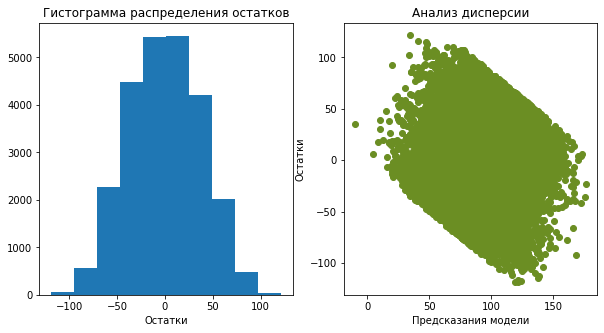

In [ ]:
# анализ остатков с помощью графиков

# рассчет остатков
residuals = y_valid-predictions

# графики по количественным признакам — гистограмму частотности
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions, y=residuals, color=color)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:** по итогам модели 1 для reg_0

-- В среднем модель ошибается примерно на 37,75 тыс. баррелей, о чем нам говорит метрика RMSE

-- Средний запас предсказанного сырья для reg_0:  92.3988 тыс.баррелей

-- Анализ остатков показывает, что на гистограмме нормальное распределение, а по графику диаграммы рассеяния отражено постоянство дисперсии, что говорит нам что модель хорошо работает.

-- Также по графику диаграммы рассеяния можем предположить, что есть какие-то скрытые зависимости между признаками, так как отражает корреляционную зависимость.

### Модель 2 для датасета reg_1

**Подготовка данных**

In [ ]:
# определяем целевой показатель

X1 = reg_1.drop(['id','product'], axis=1)
y1 = reg_1['product']

**Разделение данных на обучающую и валидационную выборки в соотношении 75:25**

In [ ]:
X1_train, X1_valid, y1_train, y1_valid = train_test_split(
    X1, y1, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
# проверим размеры выборок
# признаки обучения:

for data1 in [X1_train, X1_valid, y1_train, y1_valid]:
    print(data1.shape)
    print('________________________\n')

(75000, 3)
________________________

(25000, 3)
________________________

(75000,)
________________________

(25000,)
________________________



In [ ]:
# проверим соотношение выборок

print(f'Обучающая выборка составляет: {X1_train.shape[0]/reg_1.shape[0]:.1%} % от общего массива данных.')
print(f'Валидационная выборка составляет: {X1_valid.shape[0]/reg_1.shape[0]:.1%} % от общего массива данных.')


Обучающая выборка составляет: 75.0% % от общего массива данных.
Валидационная выборка составляет: 25.0% % от общего массива данных.


In [ ]:
# масштабируем количественные признаки

scaler1 = StandardScaler()

# список всех количественных признаков из тренировочной выборки
num_col_names1 = ['f0', 'f1', 'f2']

# обучим и трансформируем количественные признаки из тренировочной выборки

X1_train_scaled = scaler.fit_transform(X1_train[num_col_names1])

# выполним преобразование количественных признаков в тестовой выборке
X1_valid_scaled = scaler.transform(X1_valid[num_col_names1])

In [ ]:
# создаём тренировочный и валидационный датафреймы из отмасштабированных данных

X1_train_scaled = pd.DataFrame(X1_train_scaled, columns=num_col_names1)
X1_valid_scaled = pd.DataFrame(X1_valid_scaled, columns=num_col_names1)

In [ ]:
# обновляем выборки

X1_train = X1_train_scaled
X1_valid = X1_valid_scaled

In [ ]:
# инициализируем модель линейной регрессии
model_lr1  = LinearRegression()

# обучаем модель линейной регрессии на подготовленных данных

model_lr1.fit(X1_train,y1_train)

# получаем предсказания модели на тестовых данных и сохраняем результат в переменную predictions
predictions1 = model_lr1.predict(X1_valid)

In [ ]:
# расчет RMSE модели для reg_0

rmse1 = mean_squared_error(y1_valid, predictions1, squared=False)
print('RMSE для reg_1: ', round(rmse1,4))

RMSE для reg_1:  0.8903


В среднем модель ошибается примерно на 0,89 тыс. баррелей

In [ ]:
# средний запас предсказанного сырья

oil_pred_1 = predictions1.mean()
print('Средний запас предсказанного сырья для reg_1: ', round(oil_pred_1,4), 'тыс.баррелей')

Средний запас предсказанного сырья для reg_1:  68.7129 тыс.баррелей


In [ ]:
# средний запас фактически сырья

oil_real_1 = y1.mean()
print('Средний реальный запас сырья для reg_1: ', round(oil_real_1,4), 'тыс.баррелей')

Средний реальный запас сырья для reg_1:  68.825 тыс.баррелей


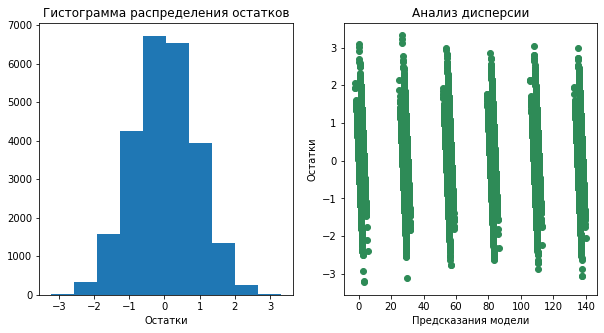

In [ ]:
# анализ остатков с помощью графиков

# рассчет остатков
residuals1 = y1_valid-predictions1

# графики по количественным признакам — гистограмму частотности
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals1)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions1, y=residuals1, color=color1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:** по итогам модели 2 для reg_1

-- В среднем модель ошибается примерно на 0,89 тыс. баррелей, о чем нам говорит метрика RMSE

-- Средний запас предсказанного сырья для reg_1:  68.7129 тыс.баррелей

-- Анализ остатков показывает, что на гистограмме остатков нормальное распределение, а по графику диаграммы рассеяния отражено постоянство дисперсии, что говорит нам что модель хорошо работает.

-- Также по графику диаграммы рассеяния можем предположить, что по этому региону отсутствуют какие-то скрытые зависимости между признаками.

### Модель 3 для датасета reg_2

**Подготовка данных**

In [ ]:
# определяем целевой показатель

X2 = reg_2.drop(['id','product'], axis=1)
y2 = reg_2['product']

**Разделение данных на обучающую и валидационную выборки в соотношении 75:25**

In [ ]:
X2_train, X2_valid, y2_train, y2_valid = train_test_split(
    X2, y2, test_size=0.25, random_state=RANDOM_STATE)

In [ ]:
# проверим размеры выборок
# признаки обучения:

for data2 in [X2_train, X2_valid, y2_train, y2_valid]:
    print(data2.shape)
    print('________________________\n')

(75000, 3)
________________________

(25000, 3)
________________________

(75000,)
________________________

(25000,)
________________________



In [ ]:
# проверим соотношение выборок

print(f'Обучающая выборка составляет: {X2_train.shape[0]/reg_2.shape[0]:.1%} % от общего массива данных.')
print(f'Валидационная выборка составляет: {X2_valid.shape[0]/reg_2.shape[0]:.1%} % от общего массива данных.')


Обучающая выборка составляет: 75.0% % от общего массива данных.
Валидационная выборка составляет: 25.0% % от общего массива данных.


In [ ]:
# масштабируем количественные признаки

scaler2 = StandardScaler()

# список всех количественных признаков из тренировочной выборки
num_col_names2 = ['f0', 'f1', 'f2']

# обучим и трансформируем количественные признаки из тренировочной выборки

X2_train_scaled = scaler.fit_transform(X2_train[num_col_names2])

# выполним преобразование количественных признаков в тестовой выборке
X2_valid_scaled = scaler.transform(X2_valid[num_col_names2])

In [ ]:
# создаём тренировочный и валидационный датафреймы из отмасштабированных данных

X2_train_scaled = pd.DataFrame(X2_train_scaled, columns=num_col_names2)
X2_valid_scaled = pd.DataFrame(X2_valid_scaled, columns=num_col_names2)

In [ ]:
# обновляем выборки

X2_train = X2_train_scaled
X2_valid = X2_valid_scaled

In [ ]:
# инициализируем модель линейной регрессии
model_lr2  = LinearRegression()

# обучаем модель линейной регрессии на подготовленных данных

model_lr2.fit(X2_train,y2_train)

# получаем предсказания модели на тестовых данных и сохраняем результат в переменную predictions
predictions2 = model_lr2.predict(X2_valid)

In [ ]:
# расчет RMSE модели для reg_0

rmse2 = mean_squared_error(y2_valid, predictions2, squared=False)
print('RMSE для reg_2: ', round(rmse2,4))

RMSE для reg_2:  40.1459


В среднем модель ошибается примерно на 40,15 тыс. баррелей

In [ ]:
# средний запас предсказанного сырья

oil_pred_2 = predictions2.mean()
print('Средний запас предсказанного сырья для reg_2: ', round(oil_pred_2,4), 'тыс.баррелей')

Средний запас предсказанного сырья для reg_2:  94.771 тыс.баррелей


In [ ]:
# средний запас фактически сырья

oil_real_2 = y2.mean()
print('Средний реальный запас сырья для reg_2: ', round(oil_real_2,4), 'тыс.баррелей')

Средний реальный запас сырья для reg_2:  95.0 тыс.баррелей


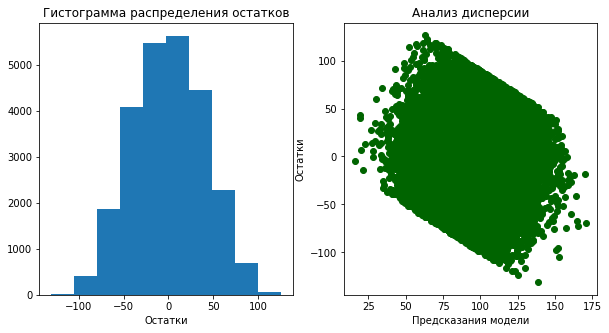

In [ ]:
# анализ остатков с помощью графиков

# рассчет остатков
residuals2 = y2_valid-predictions2

# графики по количественным признакам — гистограмму частотности
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(x=residuals2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions2, y=residuals2, color=color2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

**Вывод:** по итогам модели 3 для reg_2

-- В среднем модель ошибается примерно на 40,15 тыс. баррелей, о чем нам говорит метрика RMSE

-- Средний запас предсказанного сырья для reg_2:  94.771 тыс.баррелей

-- Анализ остатков показывает, что на гистограмме остатков нормальное распределение, а по графику диаграммы рассеяния отражено постоянство дисперсии, что говорит нам что модель хорошо работает.

-- Также по графику диаграммы рассеяния можем предположить, что по этому региону есть какие-то скрытые зависимости между признаками.

**Вывод по разделу:**
    
1) Были обучены 3 модели Линейной регрессии по каждому региону отдельно.

2) Регион 0 показал результаты: RMSE = 37,75 , средний средний запас предсказанного сырья = 92.3988 тыс.бар.

Регион 1 показал результаты: RMSE = 0,89 , средний средний запас предсказанного сырья = 68.7129 тыс.бар.

Регион 2 показал результаты: RMSE = 40,15 , средний средний запас предсказанного сырья = 94.771 тыс.бар.

3) На основе отработки моделей можно отметить также, что регионы reg_0 и reg_2 имеют похожие между собой характеристики по метрикам и средним запасам, а регион reg_1 имеет существенное отличие от остальных.

4) Анализ остатков показал, что модели по всем трем регионам отрабатывают хорошо - гистограммы имеют нормальное распределение остатков, диаграммы рассеяния показывают, что в регионах 0 и 2 есть какие-то скрытые зависимости между признаками.

## Подготовка к расчёту прибыли

### Ключевые значения для расчётов

In [ ]:
ALL_POINTS = 500
TARGET_POINTS = 200
BUDGET = 10**10
BARREL1=450
BARREL1000=450*1000
LOSS=0.025
# Среди них выбирают регион с наибольшей средней прибылью

### Рассчет объёма сырья для безубыточной разработки новой скважины

In [ ]:
min_product_stop_loss = BUDGET / (TARGET_POINTS * BARREL1000)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины - {min_product_stop_loss:.2f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей


Сформируем датафрейм - таблицу (results) с результатами исследования и значениями.

In [ ]:
dict = {'model': ['Модель reg_0'],
        'RMSE': round(rmse,2),
        'product_mean': round(oil_pred_0,2)
        }
results = pd.DataFrame(dict)

display(results)

,model,RMSE,product_mean
0,Модель reg_0,37.76,92.4


In [ ]:
# добавим все метрики в одну таблицу

results.loc[len(results.index)] = ['Модель reg_1', round(rmse1,2), round(oil_pred_1,2)]
results.loc[len(results.index)] = ['Модель reg_2', round(rmse2,2), round(oil_pred_2,2)]
display(results)

,model,RMSE,product_mean
0,Модель reg_0,37.76,92.40
1,Модель reg_1,0.89,68.71
2,Модель reg_2,40.15,94.77


**Сравним полученный объём сырья со средним запасом в каждом регионе**

In [ ]:
dict_with_result = {}

In [ ]:
dict_with_result['reg0'] = [rmse, oil_pred_0]
dict_with_result['reg1'] = [rmse1,oil_pred_1 ]
dict_with_result['reg2'] = [rmse2,oil_pred_2 ]

In [ ]:
display(dict_with_result)

{'reg0': [37.75660035026169, 92.39879990657768],
 'reg1': [0.8902801001028846, 68.7128780391376],
 'reg2': [40.145872311342174, 94.77102387765939]}

In [ ]:
for key in dict_with_result.keys():
    if dict_with_result[key][1] > min_product_stop_loss:
        print(f"Средний запас в регионе {key.upper()} - {dict_with_result[key][1]:.2f} больше необходимого минимума объема сырья - {min_product_stop_loss:.2f}")
        print('    ')
    elif dict_with_result[key][1] < min_product_stop_loss:
        print(f"Средний запас в регионе {key.upper()} - {dict_with_result[key][1]:.2f} меньше необходимого минимума объема сырья - {min_product_stop_loss:.2f}")
        print('   ')

Средний запас в регионе REG0 - 92.40 меньше необходимого минимума объема сырья - 111.11
   
Средний запас в регионе REG1 - 68.71 меньше необходимого минимума объема сырья - 111.11
   
Средний запас в регионе REG2 - 94.77 меньше необходимого минимума объема сырья - 111.11
   


**Вывод по разделу:**

1) Рассчитали достаточный объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей

2) Сформировали таблицу (results) с результатами исследования и значениями

      model	 RMSE  product_mean
            
0	Модель reg_0	37.76	92.40

1	Модель reg_1	0.89	68.71

2	Модель reg_2	40.15	94.77

Получается, что на основе метрики RMSE лучше всего отработала модель для региона  reg_1, потому что модель ошибается на минимальное значение среди всех - 0.89 тыс.баррелей.

3) Модель reg_2 имеет наибольший средний запас 94.77, который приближен к минимальному необходимому объему сырья для безубыточной разработки новой скважины

<div class="alert alert-block alert-success">
<b>Успех:</b> Значение для безубыточной разработки посчитано верно, с выводом согласен  
</div>

## Расчёт прибыли

### Скважины с максимальными значениями предсказаний

In [ ]:
predictions = pd.Series(predictions)
predictions1 = pd.Series(predictions1)
predictions2 = pd.Series(predictions2)

In [ ]:
y_valid = y_valid.reset_index(drop=True)
y1_valid = y1_valid.reset_index(drop=True)
y2_valid = y2_valid.reset_index(drop=True)

In [ ]:
# напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

def profit(target, predict, count):
    models_sorted = predict.sort_values(ascending=False) #сортируем предсказания модели по скважинам по убыванию (Выберите скважины с максимальными значениями предсказаний)

    points = target[models_sorted.index][:count] #отбираем срезом до count индексы скважин с максимальными предсказаниями
    dohod = BARREL1000 * points.sum()
    income = dohod - BUDGET
    return income # возвращаем прибыль = доход с тыс. барр. * скважины с максимальными значениями предсказаний - бюджет на разработку скважин в регионе

# просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям

### Расчет прибыли для полученного объёма сырья

In [ ]:
# рассчет прибыли для регионов

profit_0 = profit(y_valid, predictions, TARGET_POINTS)
profit_1 = profit(y1_valid, predictions1, TARGET_POINTS)
profit_2 = profit(y2_valid, predictions2, TARGET_POINTS)

print('Прибыль для предсказаний на валидационной выборке для reg_0:','{:.3f}'.format(profit_0/10**9), 'млрд. руб.')
print('Прибыль для предсказаний на валидационной выборке для reg_1:','{:.3f}'.format(profit_1/10**9), 'млрд. руб.')
print('Прибыль для предсказаний на валидационной выборке для reg_2:','{:.3f}'.format(profit_2/10**9), 'млрд. руб.')

Прибыль для предсказаний на валидационной выборке для reg_0: 3.359 млрд. руб.
Прибыль для предсказаний на валидационной выборке для reg_1: 2.415 млрд. руб.
Прибыль для предсказаний на валидационной выборке для reg_2: 2.599 млрд. руб.


**Вывод по разделу:**

1) Отобрали 200 скважин с максимальными предсказаниями по модели в каждом регионе

2) Рассчитали прибыль по этим лучшим скважинам по валидационной выборке целевого показателя.

3) Максимальная прибыль получилась у региона reg_0: 3.359 млрд. руб.

## Риски и прибыль для каждого региона

**Применение техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли**

In [ ]:


state = RandomState(12345)

In [ ]:
def bootstrap(target, predict, region):

    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace = True, random_state = state)
        preds_subsample = predict[target_subsample.index]
        values.append(profit(target_subsample, preds_subsample, 200))

    values = pd.Series(values) # расчет прибыли
    lower = values.quantile(0.025)
    chance_loss = (values < 0).mean()  # риск убытков
    interval = (values.quantile(0.025), values.quantile(0.975)) # 95%-й доверительный интервал
    mean = values.mean()
    print(region)
    print('-'*10)
    print('Средняя прибыль:{:.3f} млн. рублей'.format(mean/10**6))
    print('Доверительный интервал среднего:{}'.format(interval))
    print('2.5%-квантиль:{:.3f} млн. рублей'.format(lower/10**6))
    print('Риск:{:.2%}'.format(chance_loss))
    print('\n')

bootstrap(y_valid, pd.Series(predictions), 'reg_0')
bootstrap(y1_valid, pd.Series(predictions1), 'reg_1')
bootstrap(y2_valid, pd.Series(predictions2), 'reg_2')

reg_0
----------
Средняя прибыль:435.934 млн. рублей
Доверительный интервал среднего:(-116231612.77720818, 966504180.707376)
2.5%-квантиль:-116.232 млн. рублей
Риск:6.10%


reg_1
----------
Средняя прибыль:498.569 млн. рублей
Доверительный интервал среднего:(75315573.08898354, 911503695.0245577)
2.5%-квантиль:75.316 млн. рублей
Риск:1.00%


reg_2
----------
Средняя прибыль:412.673 млн. рублей
Доверительный интервал среднего:(-158939515.7636048, 978191201.7001915)
2.5%-квантиль:-158.940 млн. рублей
Риск:7.00%





<div class="alert alert-block alert-success">
<b>Успех:</b> С бутстрапом тоже все в порядке (сэмплирование происходит с возвращением), метрики считаются верным образом!  
</div>

**Вывод по разделу:**

1) По распределению прибыли лучше всего показал себя регион_1: риск убытков 1%, доверительный интервал в положительном диапазоне между 73 706 152 и 897 927 026 руб.

## Итоги по проекту

In [ ]:
display(results)

,model,RMSE,product_mean
0,Модель reg_0,37.76,92.4


1) Нам были предоставлены пробы нефти в трёх регионах: reg_0, reg_1, reg_2

2) Для каждого региона был уже определен набор признаков. Мы провели предобработку данных (пропуски и дубликаты отсутствуют), проведен исследовательский анализ данных (reg_0 и reg_2 схожие регионы по статистическим метрикам, а reg_1 имеет существенные различия с ними).

3) Корреляционный анализ показал, что: Для регионов reg_0 и reg_2 незначительная корреляция (<0,5) между признаками: f0 - f1 (отрицательная), f2 - product. Для региона reg_1 сильная корреляция (=1) между признаками: f2 - product.

4) Были обучены 3 модели Линейной регрессии по каждому региону отдельно (результаты обучения моделей в таблице выше. Были обучены 3 модели Линейной регрессии по каждому региону отдельно. Метрика  RMSE=0.89 по reg_1 показала наилучшие результаты модели, несмотря на то, что у этого региона самое низкое среднее значение запасов продукта.

5) Был определен достаточный объём сырья для безубыточной разработки новой скважины - 111.11 тыс. баррелей. Ни один регион не отвечает заявленным требованиям по запасам продукта.

6) Отобрали 200 скважин с максимальными предсказаниями по модели в каждом регионе. Рассчитали прибыль по этим лучшим скважинам по валидационной выборке целевого показателя. Максимальная прибыль получилась у региона reg_0: 3.359 млрд. руб.

7) Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины.

**По распределению прибыли лучше всего показал себя регион_1: риск убытков 1%, доверительный интервал в положительном диапазоне между 73 706 152 и 897 927 026 руб. А также наилучший результат по метрике RMSE=0.89**
